En esta celda definimos los objetos curva de Tipos de Interés.


1.   **Curva estática ( IRCurve)**: Ésta curva es independiente de modelo y sería la que Bootstrapearíamos de precios de IRS. Es una interpolación en splines de logaritmo de Factores de Descuento.

2.   **Curva del LGM (LGMCurve) **: Se trata de una curva dinámica (de acuerdo al LGM). En un instante futuro, esta curva depende de la curva estática y del valor que pudiera tomar la variable x.


# **Curva LGM**

Sea 

$$
dx_t = \sigma dW^{\mathcal{N}}_t \;\;\;\; s.t \;\;\;\; x(0) = 0
$$

la dinámica de la variable que establece el comportamiento de la curva de tipos de interés.

El modelo LGM, establece la relación que existe entre esta variable y el numerario a una fecha futura.

$$
N(t, x_t) = \frac{1}{B(0, t)} exp \bigg( -H_t x_t - \frac{1}{2} H_t^2 \zeta_t \bigg)
$$

donde $B(0, t)$ es el factor de descuento a vencimiento $t$ con la curva estática. $H_t = \frac{1-e^{-\kappa t}}{\kappa}$

En clase demostramos que, dado el numeraio, el factor de descuento (según LGM) a una feha futura, $B(t, T, x_t)$ , como función de $x_t$ venía dado como,

$$
B(t, T, x_t) = \frac{B(0, T)}{B(0, t)} exp\bigg( - \left( H_T - H_t \right) x_t - \frac{1}{2} \left( H_T^2 - H_t^2\right) \zeta_t \bigg)
$$


$ \textbf{Pregunta 1: Demostrar la ecuación de arriba.}$

$ \textbf{Pregunta 2: Explica cómo impacta  $H_t$ o $\kappa$ en la forma de la curva.}$


In [1]:

##########################################################
#
#     NO ES NECESARIO TOCAR ESTA FUNCIÓN
#
##########################################################


import numpy as np
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm


plt.style.use('default')

# ------------------------------------------------

# Clase Curva
class IRCurve:
  
  # CONSTRUCTOR (Da vida a la clase)
  def __init__(self, dates, dfs):
    self._ref_date = dates[0]
    self._dfs = dfs
    self._times = (dates - dates[0]) / 365.25
    self._rates_time = -np.log(dfs)
    self._curve = interp1d(self._times, self._rates_time, kind = 'cubic')
  
  # Devuelve B(t, T) = B(0, T) / B(0, t)
  def get_zero(self, t, T):
    B_0_T = np.exp(-self._curve((T-self._ref_date)/365.25))
    B_0_t = np.exp(-self._curve((t-self._ref_date)/365.25))
    
    return B_0_T / B_0_t
  
 # -----------------------------------------------------
 
def H(kappa, time):
  return (1 - np.exp(-kappa * time)) / kappa
  
  
# Definición de la clase LGM
class LGMCurve:

  # CONSTRUCTOR
  def __init__(self, IR_curve, kappa, sigma):
    self._curve = IR_curve
    self._kappa = kappa
    self._sigma = sigma

  # Numerario: N(t, xt)
  def numeraire(self, t, xt):

    time_to_t = (t - self._curve._ref_date) / 365.25
    ht = H(self._kappa, time_to_t)
    zeta_t = (self._sigma ** 2) * time_to_t

    exponent = ht * xt + 0.5 * (ht**2) * zeta_t

    return 1 / self._curve.get_zero(self._curve._ref_date, t) \
            * np.exp(exponent)
  
  # B(t, T, xt)
  def get_zero_x(self, t, T, xt):

    time_to_t = (t - self._curve._ref_date) / 365.25
    time_to_T = (T - self._curve._ref_date) / 365.25

    ht = H(self._kappa, time_to_t)
    hT = H(self._kappa, time_to_T)

    zeta = (self._sigma * self._sigma) * time_to_t

    df = self._curve.get_zero(t, T) 
    exponent = (hT -ht ) * xt + 0.5 * (hT * hT - ht * ht) * zeta 

    df *= np.exp(-exponent)

    return df
    
    
 # -----------------------------------------------------

**En la siguiente celda, inicializamos la fecha valor (today) y la curva estática (ir_curve). A lo largo de todo el ejercicio utilizaremos la misma curva**



In [2]:



#################################################################################

today = 43561 # 6 de Abril de 2019
last_date = today + 365.25 * 40

# Defino las fechas pilar para los factores de desceunto ...
pillar_dates = np.linspace(today, last_date, 50)

# Defino los rates como curva no plana
dates_rates = np.array([today, today + 365, today + 365 * 5, today + 365 * 10, \
                       today +365 * 20, today + 365 * 30, today + 365 * 50])
rates = np.array([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.028])

# Calculo los FD de acuerdo a esa estructura no plana de tipos
dfs = np.zeros(len(pillar_dates))
rate_interp = interp1d(dates_rates, rates, kind = 'linear')
for i in range( len(pillar_dates)):
  rate = rate_interp(pillar_dates[i])
  dfs[i] = (np.exp(-rate * (pillar_dates[i] - today)/ 365.25))

# Definimos IR Curve (Curva original)  
ir_curve = IRCurve(pillar_dates, dfs)

#################################################################################





# **Función de valoración de un Swaption de acuerdo al LGM**



Supongamos un Call-Money-Swap cuya fecha de comienzo denotamos por $T_a$ y última fecha de pago es $T_b$. Supongamos una opción que nos da derecho a entrar en ese IRS en la fecha $T_a$. La prima forward de este swaption (de acuerdo al LGM) puede expresarse como:

\begin{equation}
\frac{V_t}{B(t, T_a)} = E^\mathcal{N}\left(  \left( 1- B(T_a, T_b, x(T_a)) - K \sum_{j=1}^N \Delta_j B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
\end{equation}

Vimos en clase, que como el valor de este IRS es monótono en $x(T_a)$, podemos buscar el valor $x^{*}$ para el cual, 

$$
1- B(T_a, T_b, x^*) - K \sum_{j=1}^N \Delta_j B(T_a, T_j, x^*) = 0
$$


Aplicando ésto, la prima forward puede expresarse como, 

\begin{equation}
\frac{V_t}{B(t, T_a)} = E^\mathcal{N}\left(  \left( B(T_a, T_b, x^*)- B(T_a, T_b, x(T_a)) \right) ^+ \bigg| \mathcal{F}_t \right) - K \sum_{j=1}^N \Delta_j  E^\mathcal{N}\left(\left( B(T_a, T_j, x^*) -  B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
\end{equation}



Finalmente, vimos en clase que la función de valoración podríamos expresarla en función de Black-Scholes como

\begin{equation}
\frac{V_t}{B(t, T_a)} = \sum_{j=1}^N  \omega_j BS^{LN}\bigg( \text{forward} =  \frac{B(t, T_j)}{B(t, T_a)},  \text{strike} = B(T_a, T_j,  x^*), \text{mty} = T_a, \text{varianza} = \sigma^2 \left( H_{T_a} - H_{T_j}\right)^2 \bigg) 
\end{equation}

donde 

$$
\omega_j=\left\{
                \begin{array}{ll}
                  K\Delta_j & \text{si} & j = 1, \ldots, N - 1\\
                  1 + K \Delta_N & text{si} & j = N\\
                \end{array}
              \right.
$$


# **EJERCICIO 1**

Calcular el precio de un swaption payer ATM ($T_a = \text{today} + 5Y$, $T_b = T_a + 10Y$) de acuerdo al LGM ($\sigma = 1\%$, $\kappa = 1 \%$), de acuerdo a los siguientes métodos:



1.   Función Analítica: Ésta es la que describimos más arriba, y cuya función ponemos en la siguiente celda.
2.   MC: Simula por MC la variable $x(T_a)$ y calcula 
$$
\frac{1}{B(t, T_a)}E_t \left( \frac{ IRS(T_a, x(T_a))^+}{N(T_a, x(Ta))} \bigg| \mathcal{F}_t \right)
$$

Calcula también el intervalo de confianza al 95%
3. Calcula el precio por integral numérica (en este caso la función de densidad $\eta_{x(T_a)}$ es la de la X que sabemos que es un Normal(0, $\int_{t}^{T_{a}} \sigma_{s} ds$)), 

$$
\frac{1}{B(t, T_a)} \int_{-\infty}^{\infty} \frac{ IRS(T_a, x)^+}{N(T_a, x)} \eta_{x(T_a)}(x) dx
$$

Tratad de relacionar (con vuestras palabras) el método 2 y 3.


4. Resuelve el precio por integral numérica donde la función de densidad la calcules derivando dos veces la función de valoración del swaption en (1) dos veces.

$$
V(t) = \int_{-\infty}^{\infty} \left(S -K \right)^{+} \frac{\partial^2 Swptn}{\partial K^2}\bigg|_{K = S}dS
$$

Donde $Swptn$ es la prima forward del apartado (1)
$$
Swptn = E^\mathcal{N}\left(  \left( 1- B(T_a, T_b, x(T_a)) - K \sum_{j=1}^N \Delta_j B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
$$

En este apartado aparece el tema de la Delta de Dirac (Coger apuntes de Valoración de Luis y derivar).

En la siguiente celda están definidos:

1. El instrumento IRS (IRS)
2. La función de valoración de un IRS de acuerdo al LGM (LGM_IRS_Price)
3. La función de valoración analítica de un swaption (LGM_Swaption_Price)

In [3]:

# CLASE IRS
class IRS:
  
  def __init__(self, start_date, tenor, freq, fixed_coupon):
    self.start_date = start_date
    self.end_date = start_date + tenor * 365.25
    self.fix_dates = np.linspace(self.start_date, self.end_date, tenor * freq) 
    self.fixed_coupon = fixed_coupon
    self.dcf = (self.fix_dates[1:] - self.fix_dates[0:-1])/360 # Act/360
    self.fix_dates = self.fix_dates[1:]

# --------------------------------------------------------
    
# Función que valora el IRS de acuerdo al LGM
def LGM_IRS_price(value_date, irs, lgm_curve, x_at_value_date):
  
  # Pata Flotante
  floating_leg = lgm_curve.get_zero_x(value_date, irs.start_date, x_at_value_date) - \
                 lgm_curve.get_zero_x(value_date, irs.end_date, x_at_value_date) 
    
  # Pata Fija
  fixed_leg = 0
  for i in range(len(irs.fix_dates)):
    fixed_leg += irs.dcf[i] * lgm_curve.get_zero_x(value_date, \
                                                   irs.fix_dates[i], x_at_value_date)
  
  fixed_leg *= irs.fixed_coupon
  
  return (floating_leg - fixed_leg)

# --------------------------------------------------------


# Función de valoración del swaption
def LGM_Swaption_Price(value_date, irs, lgm_curve):
  
  # 1. Calculamos x_star tal que IRS(T, x_star) = 0 (en este caso es Ta)
    # Es decir, hemos realizado el calculo del irs en ta para ver el x que lo hace cero teniendo en cuenta el cupon
    # fijado en t0 (que se calcula) y va incluido en el irs
  T_mat = irs.start_date
  f_obj = lambda x : LGM_IRS_price(T_mat, irs, lgm_curve, x)
  x_star = optimize.newton(f_obj, 0)
  
  # Función anidada que calcula la put sobre ZC -------------
  def ZC_put(T_j):
    # Valoramos la última put sobre ZC
    fwd = lgm_curve.get_zero_x(value_date, T_j, 0) / \
          lgm_curve.get_zero_x(value_date, irs.start_date, 0)

    # strike B(T, T_N, x_star)
    strike = lgm_curve.get_zero_x(irs.start_date, T_j, x_star)

    # vol = (H_T - H_T_N) sigma_x
    vol = H(lgm_curve._kappa, (irs.start_date - value_date) / 365.25) - \
          H(lgm_curve._kappa, (T_j - value_date) / 365.25)
    
    vol *= lgm_curve._sigma
    
    vol = np.abs(vol)

    # Llamamos BS
    last_call = LN_BlackScholes(fwd, strike, \
                               (irs.start_date - value_date)/365.25, vol)
    last_put = last_call - (fwd - strike)
    
    return last_put
  # ------------------------------------------------------------
  
  # Iteramos por todas las fechas de pago del IRS y calculamos \
  # las puts sobre los ZC.
  
  swaption = 0 
  for i in range(len(irs.fix_dates)):
    # Calculate put
    put = ZC_put(irs.fix_dates[i])
    
    # Calculate K Delta o (1 + K Delta)
    notional = irs.dcf[i] * irs.fixed_coupon 
    if i == len(irs.fix_dates)-1:
      notional += 1 
      
      
    # Actualizamos el precio del swaption
    swaption += notional * put
  
  return swaption
  
  
# ---------------------------------------------------------------


Preparamos el modelo LGM

In [4]:
# Definimos los parametros del modelo LGM
# Tenemos inicializada la curva ir (Curva original)
sigma = 0.01
kappa = 0.01

# Inicializamos el modelo LGM
lgm_curve = LGMCurve(ir_curve, kappa, sigma)

In [5]:
# Comprobamos que LGM devuelve los factores de descuento de la curva original (IR) a las fechas pilar.

df_lgm_at_pillar_dates = [lgm_curve.get_zero_x(today, T, 0) for T in pillar_dates]

print('DF obtenidos por modelo LGM \n', df_lgm_at_pillar_dates)

print('DF originales bootstrapping \n', ir_curve._dfs)

DF obtenidos por modelo LGM 
 [1.0, 0.9966713251857411, 0.9905878975881942, 0.9834527503875067, 0.9747426352575235, 0.9645003899772523, 0.9527760558737419, 0.9405910216065432, 0.9274362972305387, 0.9132467480698189, 0.8980757410605706, 0.88197968434078, 0.8650176786311193, 0.8500408360232836, 0.8355738313765663, 0.820805510451554, 0.8057607146580462, 0.7904643861783329, 0.7749415002346169, 0.7592169985106818, 0.7433157239695547, 0.7272623572978114, 0.7110813551950409, 0.6947968907139784, 0.6784327958429797, 0.6620125065079683, 0.6455590101558262, 0.6290947960655483, 0.6126418085174099, 0.5962214029340416, 0.5798543050907563, 0.563560573475821, 0.5473595648647405, 0.5312699031561023, 0.5153094515001974, 0.4994952877356182, 0.48384368313338844, 0.4694843174143188, 0.45824234894147803, 0.44718010443800754, 0.436297617482579, 0.42559481428173607, 0.41507151634102774, 0.40472744317431036, 0.3945622150470678, 0.3845753557496561, 0.37476629539644546, 0.3651343732468857, 0.355678840544603, 0.3

In [6]:
#PLOT
f, ax = plt.subplots()

ax.plot(pillar_dates, ir_curve._dfs, 'o', label = 'DF Originales')
ax.plot(pillar_dates, df_lgm_at_pillar_dates, 'x', label = 'DF LGM')

ax.legend()

#### 1 Función Analítica: Ésta es la que describimos más arriba, y cuya función ponemos en la siguiente celda.

In [7]:
# Definimos función de Black Scholes
def LN_BlackScholes(S0, K, T, sigma):
  d1 = (np.log(S0/K) + 0.5 *  (sigma**2) * T )/(np.sqrt(T) * sigma)
  d2 = d1 - sigma * np.sqrt(T)
  
  return S0 * norm.cdf(d1) - K * norm.cdf(d2) 

Parametros

In [8]:
# t < Ta < Tb
# Start day
Ta = today + 365.25*5
# End day
Tb = Ta + 365.25*10
# Tenor (Tb-Ta)/365.25
tenor = (Tb - Ta)/365.25

freq = 2 # Paga cada seis meses

In [9]:
# Definimos el cupon que hace cero el valor del IRS en t0

f_obj = lambda k: LGM_IRS_price(today, IRS(Ta, tenor, freq, k), lgm_curve, 0)

k = optimize.newton(f_obj, 0.02)

print('Este es el K (cupón fijo) que hace que mi IRS sea ATM (P_fl = P_fi) en t0: \n', k)


Este es el K (cupón fijo) que hace que mi IRS sea ATM (P_fl = P_fi) en t0: 
 0.020942532876816206


C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [10]:
# ATM (Ta=today+5Y , Tb=Ta+10Y)
# sigma = 0.01
# kappa = 0.01

# IRS(start_date, tenor, freq, fixed_coupon)
irs = IRS(Ta, tenor, freq, k)

swaption_premium = LGM_Swaption_Price(today, irs, lgm_curve)

C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [11]:
# Esta es la prima forward:
print('Prima Forward: \n', swaption_premium)

Prima Forward: 
 0.07315000431655852


In [12]:
# Calculamos el factor de descuento de today a Ta - B(t,Ta) = B(0,Ta)/B(0,t)
# Usamos modelo LGM (con X_t = 0) y comprobamos que es igual a la que obtendria con ir_curve

print('Modelo LGM: \n', lgm_curve.get_zero_x(today, Ta, 0))
print('DF ir_curve: \n', ir_curve.get_zero(today, Ta))

Modelo LGM: 
 0.9512753005173394
DF ir_curve: 
 0.9512753005173394


In [13]:
# Prima en today (MULTIPLICO POR EL FACTOR DE DTO PARA TRAER DE TA A TODAY)

print('Prima today: \n', lgm_curve.get_zero_x(today, Ta, 0) * swaption_premium)

Prima today: 
 0.06958579233907888


#### 2 MC: Simula por MC la variable  x(Ta)  y calcula


$$
\frac{1}{B(t, T_a)}E_t \left( \frac{ IRS(T_a, x(T_a))^+}{N(T_a, x(Ta))} \bigg| \mathcal{F}_t \right)
$$

In [14]:
# Simulamos 1000000 de posibles X_Ta

x_at_Ta = np.random.normal(size=100000) * lgm_curve._sigma * np.sqrt((Ta-today)/365.25)

# Estos dos elementos van dentro de la esperanza:
# 1.- Valoramos IRS con el LGM, lo valoramos en Ta, usando un modelo LGM
irs_at_Ta = LGM_IRS_price(Ta, irs, lgm_curve, x_at_Ta)

# 2.- Calculamos los numerarios con X_Ta
irs_at_Ta /= lgm_curve.numeraire(Ta, x_at_Ta)

print('Simulaciones con IRS positivo: \n', sum(irs_at_Ta > 0))
# 3.- Cogemos la parte positiva del IRS
irs_at_Ta = np.maximum(irs_at_Ta, 0)

# Calculamos la media para obtener el valor del IRS en Ta
premium_MC = np.mean(irs_at_Ta)
print('Premium Forward del IRS en Ta: \n', premium_MC)

Simulaciones con IRS positivo: 
 58267
Premium Forward del IRS en Ta: 
 0.06967747418440741


In [15]:
# Lo dividimos del Factor de descuento (ESTO... NO SERIA CAPITALIZAR EN LUGAR DE DESCONTAR????)
print('Usando DF de curva IR: \n', premium_MC / ir_curve.get_zero(today, Ta))
print('Usando DF obtenidos por LGM (con X_t = 0): \n', premium_MC / lgm_curve.get_zero_x(today, Ta, 0))

Usando DF de curva IR: 
 0.07324638214249247
Usando DF obtenidos por LGM (con X_t = 0): 
 0.07324638214249247


Recordemos:

Formula analitica es:

\begin{equation}
\frac{V_t}{B(t, T_a)} = E^\mathcal{N}\left(  \left( B(T_a, T_b, x^*)- B(T_a, T_b, x(T_a)) \right) ^+ \bigg| \mathcal{F}_t \right) - K \sum_{j=1}^N \Delta_j  E^\mathcal{N}\left(\left( B(T_a, T_j, x^*) -  B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
\end{equation}

Esta es la prima forward, si la descuento aplicando:

\begin{equation}
V_t = B(t, T_a) E^\mathcal{N}\left(  \left( B(T_a, T_b, x^*)- B(T_a, T_b, x(T_a)) \right) ^+ \bigg| \mathcal{F}_t \right) - K \sum_{j=1}^N \Delta_j  E^\mathcal{N}\left(\left( B(T_a, T_j, x^*) -  B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
\end{equation}

Entonces obtengo la prima en $t_{0} = t$

Mientras que al obtener el valor por MC obtengo el valor directamente en $t_{0} = t$. Por lo cual, para que sea igual a la prima forward, necesito capitalizarla, es decir, necesito hacer esto: 

$$
\frac{1}{B(t, T_a)}E_t \left( \frac{ IRS(T_a, x(T_a))^+}{N(T_a, x(Ta))} \bigg| \mathcal{F}_t \right)
$$


In [16]:
print('Prima forward (Valor en Ta) (prima analitica): \n', swaption_premium)
print('Prima analitica descontada a today (multiplica al B(today, Ta)): \n', swaption_premium * lgm_curve.get_zero_x(today, Ta, 0))

print('\n')
print('Ahora imprimimos las primas obtenidas por MC')
print('\n')

print('Prima MC directa (es el valor en today): \n', premium_MC)
print('Prima MC capitalizada a today (dividida por B(today, Ta)): \n', premium_MC / lgm_curve.get_zero_x(today, Ta, 0))


Prima forward (Valor en Ta) (prima analitica): 
 0.07315000431655852
Prima analitica descontada a today (multiplica al B(today, Ta)): 
 0.06958579233907888


Ahora imprimimos las primas obtenidas por MC


Prima MC directa (es el valor en today): 
 0.06967747418440741
Prima MC capitalizada a today (dividida por B(today, Ta)): 
 0.07324638214249247


In [17]:
#LGMCurve(ir_curve, kappa, sigma)
lgm_curve._kappa
lgm_curve._curve
lgm_curve._sigma
irs.fixed_coupon

0.020942532876816206

In [18]:
LGM_IRS_price(Ta, irs, lgm_curve, k)

0.18816337230509647

#### **3** Calcula el precio por integral numérica

En este caso la función de densidad $\eta_{x(T_a)}$ es la de la X que sabemos que es un Normal(0, $\int_{t}^{T_{a}} \sigma_{s} ds$) 

$$
\frac{1}{B(t, T_a)} \int_{-\infty}^{\infty} \frac{ IRS(T_a, x)^+}{N(T_a, x)} \eta_{x(T_a)}(x) dx
$$

In [19]:
# Se define el integrando

def swaption_integrand(x):
    
    # Calculo valor IRS
    irs_at_Ta = LGM_IRS_price(Ta, irs, lgm_curve, x)
    
    # Se divide por el numerario
    irs_at_Ta /= lgm_curve.numeraire(Ta, x)
    
    # Se busca el maximo
    irs_at_Ta = np.maximum(irs_at_Ta, 0)
    
    # Definimos la función de densidad
    # Sigma
    sigma_x = lgm_curve._sigma * np.sqrt((Ta - today)/365.25)
    pdf = norm.pdf(x, loc = 0, scale = sigma_x)
    
    return irs_at_Ta * pdf
    

In [20]:
#irs_at_Ta = LGM_IRS_price(Ta, irs, lgm_curve, x_star_Ta)
#irs_at_Ta

In [21]:
# Definimos x_star_Ta como limite inferior de evaluación de la integral.

f_obj_Ta = lambda x : LGM_IRS_price(Ta, irs, lgm_curve, x)
x_star_Ta = optimize.newton(f_obj_Ta, 0)
print(x_star_Ta)

-0.00462148797394625


In [22]:
# Resolvemos la integral:

import scipy.integrate as integrate

integrate.quad(swaption_integrand, x_star_Ta, 0.5)

(0.06958579233904794, 1.1362823170253005e-14)

In [23]:
# Resolución de integrales por metodo de trapecios (suma de areas por alturas)
def trap(f, xmin, xmax, npoints=10):
    """
    computes the integral of f using trapezoid rule
    """
    area = 0
    x = np.linspace(xmin, xmax, npoints)
    N = len(x)
    dx = x[1] - x[0]
    
    for k in range(1, N):
        area += (f(x[k - 1]) + f(x[k])) * dx / 2
        
    return area

In [24]:
trap(swaption_integrand, x_star_Ta, 0.5, 100)

0.06928471257899252

Hay que picar la parte de Luis.

Definiremos dos funciones, una la pde_swap, en la cual hay que realizar una optimización para buscar los valores de $X^{\star}_{T_a}$ que hacen que $$(S_{a,b}(X^{\star}_{T_a}) - K) = 0$$

$$S(X^{\star}_{T_a}) = K$$

Una vez definido esto, tendríamos la funcion de densidad:

$$\sum_{j = a+1}^{b}B(T_a, T_j,X^{\star}_{T_a}) \eta_{X}(X^{\star}_{T_a}) = \eta_{swaption}(k)$$

Para por fin poder calcular:

$$V(t) = \displaystyle \int_{-\infty}^{\infty}(S - K)^{+}\eta_{swaption}(S)dS$$

Tipo Swap:

$$
S(x) = \displaystyle \dfrac{1 - B(T_a, T_b, x(T_a))}{\sum_{j=a+1}^{b}\Delta_j B(T_a, T_j, x(T_a))}
$$


In [25]:
x_star_Ta
irs.fix_dates

len(irs.dcf) == len(irs.fix_dates)

True

In [26]:
# Definimos tipo swap

lgm_curve.get_zero_x(Ta, Tb, x_star_Ta)
tipo_swap_denominador = []
for i in range(len(irs.fix_dates)):
    
    tipo_swap_denominador.append(irs.dcf[i] * lgm_curve.get_zero_x(Ta, irs.fix_dates[i], x_star_Ta))
    
print((1-lgm_curve.get_zero_x(Ta, Tb, x_star_Ta))/sum(tipo_swap_denominador))

irs.fixed_coupon

#f_obj = lambda k: LGM_IRS_price(today, IRS(Ta, tenor, freq, k), lgm_curve, 0)

#f_obj_Ta = lambda x : LGM_IRS_price(Ta, irs, lgm_curve, x)
#x_star_Ta = optimize.newton(f_obj_Ta, 0)

0.02094253287680961


0.020942532876816206

In [27]:
def ajuste_tipo_swap_k(Ta, Tb, x):
    
    tipo_swap_denominador = []
    
    for i in range(len(irs.fix_dates)):
        tipo_swap_denominador.append(irs.dcf[i] * lgm_curve.get_zero_x(Ta, irs.fix_dates[i], x))
        
    return((1-lgm_curve.get_zero_x(Ta, Tb, x))/sum(tipo_swap_denominador))




In [28]:
f_obj_tipo_swap = lambda x: ajuste_tipo_swap_k(Ta, Tb, x)
optimize.newton(f_obj_tipo_swap, 0)

-0.028190501538187418

In [29]:
def prueba(strike):
    
    irs_prueba = IRS(Ta, tenor, freq, strike)
    
    # Calculo valor IRS
    irs_at_Ta = LGM_IRS_price(Ta, irs_prueba, lgm_curve, x_star_Ta)
    
    # Se divide por el numerario
    irs_at_Ta /= lgm_curve.numeraire(Ta, x_star_Ta)
    
    # Se busca el maximo
    irs_at_Ta = np.maximum(irs_at_Ta, 0)
    
    # Definimos la función de densidad
    # Sigma
    sigma_x = lgm_curve._sigma * np.sqrt((Ta - today)/365.25)
    pdf = norm.pdf(strike, loc = 0, scale = sigma_x)
    
    return irs_at_Ta * pdf
    

In [30]:
irs_prueba = IRS(Ta, tenor, freq, k)

irs_at_Ta = LGM_IRS_price(Ta, irs_prueba, lgm_curve, x_star_Ta)
irs_at_Ta /= lgm_curve.numeraire(Ta, x_star_Ta)
irs_at_Ta = np.maximum(irs_at_Ta, 0)
sigma_x = lgm_curve._sigma * np.sqrt((Ta - today)/365.25)
irs_at_Ta


C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


0.0

In [31]:
prueba(k)

C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


0.0

In [32]:
integrate.quad(prueba, x_star_Ta, 0.5)

C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(0.04927017962403202, 3.1504435730467694e-09)

In [33]:
trap(prueba, x_star_Ta, 0.5, 1000)

C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


0.04927363003399639

$$
E[\delta (S_{a,b}(X_{T_{a}}) - k)] = \displaystyle \int_{-\infty}^{\infty} \delta (S_{a,b}(X_{T_{a}}) - k) \eta_{x(T_a)}(x) dx = \eta_{X_{T_{a}}}(k)
$$

$$
X_{T_{a}} \rightarrow N (0, \displaystyle \int_{0}^{T_a}\sigma_s^2 ds)
$$

# **EJERCICIO 2. **

Para el Swaption con las características del ejercicio 1,  ($T_a = \text{today} + 5Y$, $T_b = T_a + 10Y$) y  de acuerdo al LGM ($\sigma = 1\%$, $\kappa = 1 \%$),  calculad para los Strikes en ATM difference (ATM Differece = K - Forward) = $-200\;  bp, -100 \; bp, -50 \;  bp, 0 \; bp, 50 \; bp, 100 \; bp, 200 \; bp$ el precio del Swaption Payer Physical Settled vs Cash-Settled.

Recordad que el precio del Swaption Physical-Settled es el que habéis calculado en ejercicio 1. El Pay-Off a vencimiento del Csh-Settled es

$$
Swptn^\text{Cash}(T_a) = \left( S(T_a, x(T_a)) - K \right)^+ \sum_{j=1}^N \frac{ \Delta_j }{\left(1 + S(T_a, x(T_a)) \right)^{(T_j - T_a)}}
$$

Comparad ambas gráficas y tratad de justificar los resultados.

**Nota:** Podéis utilizar el método numérico que consideréis más oportuno. Espero algún comentario en relación a la elección del método.

**Nota:** 100 bp = 1% = 0.01


In [34]:
print(Ta, tenor, freq, k)

45387.25 10.0 2 0.020942532876816206


Para el calculo del ATM difference:

ATM Difference = K - Forward
    
    Forward - Es el K definido en T0 que hace que el contrato sea ATM en T0 (lo definimos # Definimos el cupon que hace cero el valor del IRS en t0)

Por lo tanto, tenemos que definir los nuevos K, teniendo en cuenta los ATM Difference.

K = ATM Difference + Forward

Puntos Basicos:


1.   1 Bp = 0.01%
2.   10 Bp = 0.1%
3.    50 Bp = 0.5%
4.    100 Bp = 1%
5.    1000 Bp = 10%
6.    10000 Bp = 100%



#### 1.- Precio del Swaption Physical-Settled

In [35]:
# IRS(start_date, tenor, freq, fixed_coupon)
#irs = IRS(Ta, tenor, freq, k)

k_diff = [-0.02, -0.01, -0.005, 0, 0.005, 0.01, 0.02]
physical_settle = []
for k_bp in k_diff:
    
    physical_settle.append(LGM_Swaption_Price(value_date = today, 
                                              irs = IRS(Ta, tenor, freq, k+k_bp), 
                                              lgm_curve = lgm_curve))

#LGM_Swaption_Price(value_date = today, irs = IRS(Ta, tenor, freq, k), lgm_curve = lgm_curve)

C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [36]:
print('Swaption_premium: \n', physical_settle)
print('K - K_diff: \n', k+k_diff)
k + k_diff[-1]

Swaption_premium: 
 [0.19796007913825042, 0.12757254194208956, 0.09815566080915465, 0.07315000431655852, 0.05267083617542949, 0.03655917484210827, 0.01565486659968828]
K - K_diff: 
 [0.00094253 0.01094253 0.01594253 0.02094253 0.02594253 0.03094253
 0.04094253]


0.04094253287681621

In [37]:
plt.plot(k+k_diff, physical_settle)

plt.xlabel('k+k_diff')
plt.ylabel('Swaption Premium')
plt.title('Swaption Physical-Settled');

### 2.- Precio del Swaption Payer Cash-Settled

# **EJERCICIO 3. **

Para el Swaption con las características del ejercicio 1,  ($T_a = \text{today} + 5Y$, $T_b = T_a + 10Y$) , asumamos que el precio del swaption payer de mercado viene establecido por el LGM ($\sigma = 1\%$, $\kappa = 1 \%$).


Para distintos valores de $\kappa = -5\%, -3\%, -1\%, 1\%, 3\%, 5\%$


1. Calculad el nuevo valor de $\sigma$ tal que el precio del swaption ATM es igual al original ($\sigma = 1\%$, $\kappa = 1 \%$).
2. Pintar el smile de volatilidad en términos normales para los strikes (en ATM difference) $-200\;  bp, -100 \; bp, -50 \;  bp, 0 \; bp, 50 \; bp, 100 \; bp, 200 \; bp$


Parte 1: Hay que buscar vol implicita (una optimización)


In [38]:

from scipy.stats import norm

# Fórmula de BS en términos normales. La vais a necesitar para calcular el smile en términos normales.


# ----------------------------------------------------------------


# EVALUATE BS ..
def BS_norm_price(F, K, T, vol):
  '''
  Normal Black-Scholes
  '''
  sigma_sqrt_t = vol * np.sqrt(T)
  d1 = (F - K) / sigma_sqrt_t
  
  return (F-K) * norm.cdf(d1) + sigma_sqrt_t * norm.pdf(d1)
# ----------------------------------------------------------------



### 1.- Calculad el nuevo valor de $\sigma$ tal que el precio del swaption ATM es igual al original ($\sigma = 1\%$, $\kappa = 1 \%$).

In [39]:
lgm_curve = LGMCurve(IR_curve=ir_curve, kappa=0.01, sigma=sigma)

# IRS(start_date, tenor, freq, fixed_coupon)
irs = IRS(Ta, tenor, freq, k)

LGM_Swaption_Price(value_date=today, irs=irs, lgm_curve=lgm_curve)

C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


0.07315000431655852

In [40]:
swaption_premium


0.07315000431655852

In [41]:
# Optimización respecto a kappa

fobj = lambda x: LGM_Swaption_Price(today, irs, 
                                    LGMCurve(IR_curve=ir_curve, kappa=0.01, sigma=x)) - swaption_premium
optimize.newton(fobj, sigma)

0.01

In [42]:
#  -5\%, -3\%, -1\%, 1\%, 3\%, 5\%
kappa = [-0.05, -0.03, -0.01, 0.01, 0.03, 0.05]
sigma_kappa = []

for k in kappa:
    
    fobj = lambda x: LGM_Swaption_Price(today, irs, 
                                    LGMCurve(IR_curve=ir_curve, kappa=k, sigma=x)) - swaption_premium
    sigma_kappa.append(optimize.newton(fobj, sigma))

In [43]:
print('Vol implicita para los distintos kappa: \n', sigma_kappa)
%matplotlib inline

Vol implicita para los distintos kappa: 
 [0.005491714628373769, 0.0067285034083056, 0.008216414746342679, 0.01, 0.012130468638656987, 0.014666513687089931]


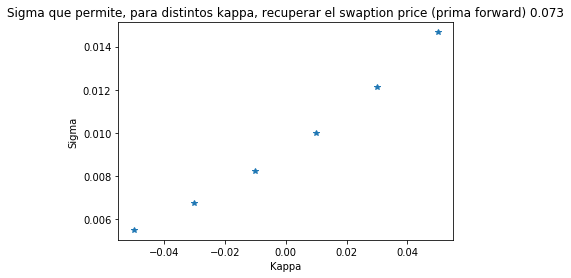

In [44]:
str_swaption_premium = str(np.around(swaption_premium, decimals= 3))
plt.plot(kappa, sigma_kappa, '*')
plt.xlabel('Kappa')
plt.ylabel('Sigma')
plt.title('Sigma que permite, para distintos kappa, recuperar el swaption price (prima forward) ' +  str_swaption_premium);

### 2.- Pintar el smile de volatilidad en términos normales para los strikes (en ATM difference) $-200\;  bp, -100 \; bp, -50 \;  bp, 0 \; bp, 50 \; bp, 100 \; bp, 200 \; bp$

In [45]:
print(swaption_premium)
print(physical_settle)
k = 0.020942532876816206
print(k)
print(kappa)

0.07315000431655852
[0.19796007913825042, 0.12757254194208956, 0.09815566080915465, 0.07315000431655852, 0.05267083617542949, 0.03655917484210827, 0.01565486659968828]
0.020942532876816206
[-0.05, -0.03, -0.01, 0.01, 0.03, 0.05]


In [46]:
swaption_premium

physical_settle

lgm_curve = LGMCurve(ir_curve, kappa, sigma)

k_diff = [-0.02, -0.01, -0.005, 0, 0.005, 0.01, 0.02]
physical_settle = []
for k_bp in k_diff:
    
    physical_settle.append(LGM_Swaption_Price(value_date = today, 
                                              irs = IRS(Ta, tenor, freq, k+k_bp), 
                                              lgm_curve = lgm_curve))
    
    
def BS_norm_price(F, K, T, vol):
  '''
  Normal Black-Scholes
  '''
  sigma_sqrt_t = vol * np.sqrt(T)
  d1 = (F - K) / sigma_sqrt_t
  
  return (F-K) * norm.cdf(d1) + sigma_sqrt_t * norm.pdf(d1)

C:\Users\e051692\Documents\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


TypeError: bad operand type for unary -: 'list'

In [47]:
print(swaption_premium)
print(physical_settle)

0.07315000431655852
[]


In [ ]:
lgm_curve.get_zero_x(t = today, T = Ta, xt = 0)
fobjt = lambda x: BS_norm_price(lgm_curve.get_zero_x(t = today, T = Ta, xt = 0), k_diff[0], tenor, x) - physical_settle[1]

optimize.newton(fobjt, 0.01, maxiter = 100)

In [59]:
vol_implicita = []
# k porque forward = k del atm diference
k = 0.020942532876816206
for i in range(len(k_diff)):

    fobjt = lambda x: BS_norm_price(k, k + k_diff[i], (Ta - today)/365.25, x) - swaption_premium
    #fobjt = lambda x: swaption_premium - BS_norm_price(k, k + k_diff[i], tenor, x)
    vol_implicita.append(optimize.newton(fobjt, 0.01, maxiter = 100))

In [60]:
vol_implicita

[0.07022219225543064,
 0.07626495084722121,
 0.07916695399304165,
 0.0820010263347562,
 0.08477403349039236,
 0.08749174593410104,
 0.09278021595221318]

In [61]:
for i in range(len(vol_implicita)):
    print(BS_norm_price(k, k+k_diff[i], (Ta - today)/365.25, vol_implicita[i]))


0.07315000431655849
0.07315000431656801
0.07315000431655852
0.07315000431655852
0.07315000431655853
0.07315000431656403
0.07315000431655852


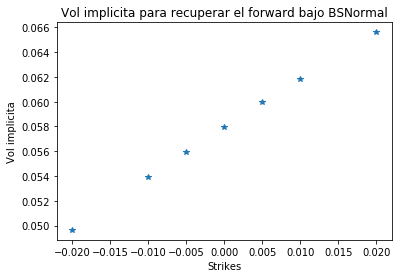

In [58]:
plt.plot(k_diff, vol_implicita, '*')
plt.xlabel('Strikes')
plt.ylabel('Vol implicita')
plt.title('Vol implicita para recuperar el forward bajo BSNormal');

In [52]:
print('Swaption premium utilizando BSNormal: \n', BS_norm_price(k, k_diff[0], tenor, vol_implicita[0]))
print('Swaption premium physical_settle ATM difference \n', physical_settle)

Swaption premium utilizando BSNormal: 
 0.11056272159727848
Swaption premium physical_settle ATM difference 
 []


In [73]:
%%latex

UsageError: %%latex is a cell magic, but the cell body is empty.



Alternativa propuesta por Carlos y que tiene mas sentido

En este caso lo que hacemos es:

    - Calibramos la volatilidad del swaption (usando LGM_SWAPTION_PRICE) para obtener la vol que nos daria el swaption_premium original para cada kappa
    - Calculamos el annuity (A_3)
    - Con esa vol original y para cada atm_diff calculamos el valor del lgm_swaption_price y le restamos annuity * BSNOrmal optimizando encontraremos la vol implicita

[[0.01086776 0.00987877 0.00960841 0.00942498 0.00929816 0.00920821
  0.00909317]
 [0.0108406  0.00986319 0.00960047 0.00942498 0.00930612 0.00922407
  0.00912462]
 [0.01081347 0.00984763 0.00959255 0.00942498 0.00931406 0.00923987
  0.00915589]
 [0.01078649 0.00983215 0.00958468 0.00942498 0.00932194 0.00925555
  0.00918689]
 [0.01075977 0.00981681 0.00957688 0.00942498 0.00932974 0.00927105
  0.00921748]
 [0.0107334  0.00980168 0.00956919 0.00942498 0.00933741 0.0092863
  0.00924756]]
8.700388789105494


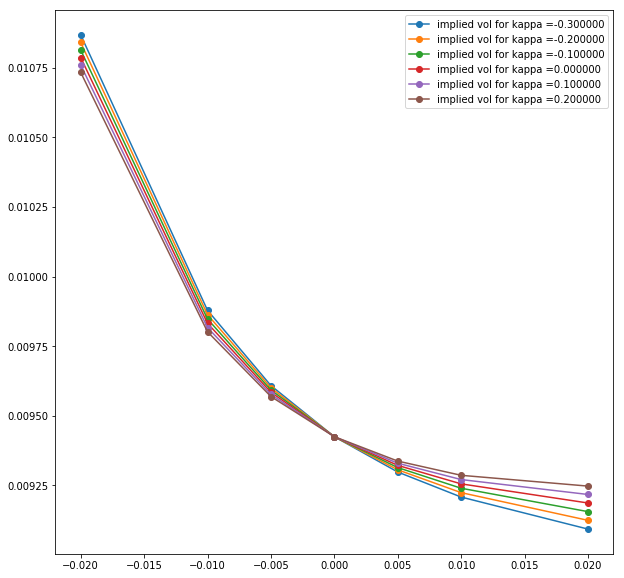

In [71]:
%matplotlib inline
sigma_1 = 0.01
#Impacto del kappa
kappa_test_up=0.3
kappa_test_down=-0.3
kappa_test_range=np.linspace(kappa_test_down, kappa_test_up, 7) 
f, ax = plt.subplots(1,sharey=False)

kappa_3 = np.linspace(-0.05,0.05, 6)
sigma_3 = np.zeros(len(kappa_3))
ATM_dif=np.array([-200, -100, -50, 0, 50, 100, 200])*1e-4
sigma_BS = np.zeros((len(kappa_3), len(ATM_dif )))

for i in range(len(kappa_3)):                     
  f_obj = lambda sigma_obj : LGM_Swaption_Price(today, IRS(Ta, 10, 2, k), 
                                                LGMCurve(ir_curve, kappa_3[i], sigma_obj)) - swaption_premium
  sigma_obj = optimize.newton(f_obj, sigma_1)
  sigma_3[i]=sigma_obj #He calibrado el modelo para el kappa considerado

  for j in range(len(ATM_dif)): 
    sigma_BS[i][j] = 0
    irs_3 = IRS(Ta, 10, 2, k+ ATM_dif[j])
    A_3 = np.dot(irs_3.dcf,ir_curve.get_zero(today,irs_3.fix_dates))

    f_obj = lambda sigma_BS_obj : LGM_Swaption_Price(today, irs_3, 
                                                     LGMCurve(ir_curve, 
                                                              kappa_3[i], sigma_3[i])) - A_3 * BS_norm_price(k, 
                                                                                                             k +ATM_dif[j], 
                                                                                                             (Ta - today)/365.25, 
                                                                                                             sigma_BS_obj)          

    sigma_BS_obj = optimize.newton(f_obj, sigma_3[i])

    sigma_BS [i] [j] = sigma_BS_obj           
                    

  
  
  ax.plot(ATM_dif, sigma_BS [i] [:], 'o-',label = 'implied vol for kappa =%f' %kappa_test_range[i] )
  ax.legend()






f.set_size_inches(10, 10)
  
  
  
print(sigma_BS)

print(A_3)
